In [14]:
import os
import sys
import pickle
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from bayesmf.scripts.utils.model import run_kfold_xval
from bayesmf.scripts.utils.dataset import make_insilico_dataset, make_downsampled_dataset
from bayesmf.models.bmf import BMF, StochasticBMF

%reload_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
X, _ = make_insilico_dataset()

In [113]:
idxs = np.arange(X.shape[1])

np.random.seed(22690)
np.random.shuffle(idxs)

X_train = X[:, idxs[:800]]
X_test = X[:, idxs[800:]]

In [114]:
factorizer = BMF(K=15, random_state=22690, init='nmf')
factorizer.fit(X_train) 
W = factorizer.transform(X_test, attr='Et').T 
H = factorizer.Eb.T

/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)
/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)


In [115]:
X_pred = np.matmul(W, H)
sqerr = (X_test.T - X_pred)**2

In [116]:
x = np.sqrt(np.sum(X_pred, axis=1))
y = np.sqrt(np.sum(sqerr, axis=1) / 100)

/home/sxchao/.conda/envs/snakes/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


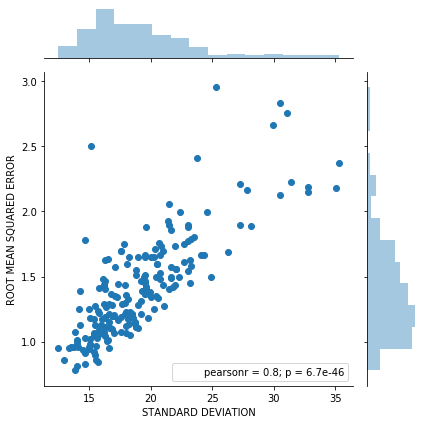

In [117]:
jp = sns.jointplot(x=x, y=y, stat_func=stats.pearsonr)
jp.set_axis_labels('STANDARD DEVIATION', 'ROOT MEAN SQUARED ERROR')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.manifold import TSNE

In [112]:
X, _ = make_downsampled_dataset()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [121]:
#X_train = X[:, idxs[:800]]
#X_test = X[:, idxs[800:]]

factorizer = BMF(K=15, random_state=22690, init='nmf')
factorizer.fit(X)

#W = factorizer.transform(X_test, attr='Et').T 
W = factorizer.Et.T
H = factorizer.Eb.T
X_pred = np.matmul(W, H)

/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)


In [67]:
#emb = TSNE(n_components=2).fit_transform(W)
#emb.shape

(1000, 2)

In [107]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(W)
embedding.shape

(1000, 2)

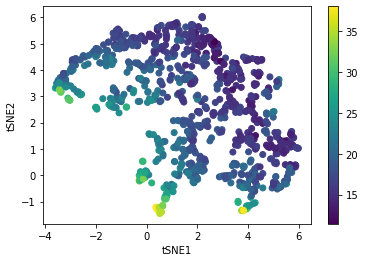

In [124]:
c = np.sqrt(np.sum(X_pred, axis=1))
#sqerr = (X.T - X_pred)**2
#c = np.sqrt(np.sum(sqerr, axis=1) / 100)

plt.scatter(x=embedding[:,0], y=embedding[:,1], c=c)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar()
plt.show()

In [109]:
import sklearn.cluster as cluster

#c = make_insilico_dataset(return_assignments=True)
c = cluster.KMeans(n_clusters=10).fit_predict(W)
c.shape

(1000,)

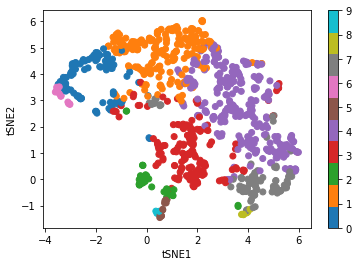

In [110]:
plt.scatter(x=embedding[:,0], y=embedding[:,1], c=np.array(c), cmap='tab10')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar()
plt.show()

In [111]:
from collections import Counter
d = Counter(c)

sorted(d.items(), key = lambda x: x[1], reverse=True)

[(4, 312),
 (1, 230),
 (3, 170),
 (0, 111),
 (7, 93),
 (2, 40),
 (6, 15),
 (5, 14),
 (8, 9),
 (9, 6)]

In [126]:
mean_squared_error(X[:,:200].T, np.zeros(X[:,:200].T.shape), squared=False)

12.022478945708327